**K Means alternatif**

In [ ]:
# Start writing code here...from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
spotify_songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')


Q1 = np.percentile(spotify_songs.duration_ms, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(spotify_songs.duration_ms, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

"""
mask = (spotify_songs.duration_ms < (Q3+1.5*IQR))
mask2 = spotify_songs.duration_ms > (Q1-1.5*IQR)
spotify_data_cleaned = spotify_songs.loc[mask]
spotify_data_cleaned = spotify_data_cleaned.loc[mask2]
"""
spotify_data_cleaned = spotify_songs
spotify_data_cleaned.track_album_release_date.str[:4]
spotify_data_cleaned.track_album_release_date.str[5:7]
spotify_data_cleaned = spotify_data_cleaned.assign(
    track_album_release_month = spotify_data_cleaned.track_album_release_date.str[5:7],
    track_album_release_year = spotify_data_cleaned.track_album_release_date.str[:4],
)
spotify_data_cleaned.drop(columns="track_album_release_date",inplace=True)
spotify_data_cleaned.track_album_release_year = spotify_data_cleaned.track_album_release_year.astype("int64")
"""
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]
"""


'\nmask = (spotify_data_cleaned.track_popularity > 0)\nspotify_data_cleaned = spotify_data_cleaned.loc[mask]\n'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalisation():
    columns = ["track_popularity","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo", "duration_ms", "track_album_release_year"]
    data_norme = spotify_data_cleaned[columns]
    scaler = MinMaxScaler(feature_range=(0,1))
    data_norme = pd.DataFrame(scaler.fit_transform(data_norme), columns=columns)
    return data_norme



In [ ]:
data_normed = normalisation()
mask = spotify_songs.duration_ms > (Q1-1.5*IQR)

In [ ]:
data_bf_np = data_normed
data_normed = data_normed.to_numpy()
data_normed

array([[0.66      , 0.76093591, 0.9159853 , ..., 0.50967257, 0.37125397,
        0.98412698],
       [0.67      , 0.73855544, 0.81496762, ..., 0.41752422, 0.30867441,
        0.98412698],
       [0.7       , 0.68667345, 0.93098792, ..., 0.51790845, 0.33595298,
        0.98412698],
       ...,
       [0.14      , 0.53814852, 0.82096867, ..., 0.53453475, 0.40114439,
        0.9047619 ],
       [0.15      , 0.63682604, 0.8879804 , ..., 0.5346141 , 0.70732761,
        0.9047619 ],
       [0.27      , 0.61342828, 0.8839797 , ..., 0.53451387, 0.64907261,
        0.9047619 ]])

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


In [ ]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

In [ ]:
!pip install k_means_constrained

     |████████████████████████████████| 561 kB 16.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.5 MB 36.1 MB/s 
  Created wheel for k-means-constrained: filename=k_means_constrained-0.7.0-cp37-cp37m-linux_x86_64.whl size=426600 sha256=6a1000d187a6205e460f3693d1b16588794297f6133f129560c301ec591a3685
  Stored in directory: /root/.cache/pip/wheels/97/2e/70/c473dfd41bc709dd3c2a89ae09d345a5ffb77d1906a2a77176
Successfully built k-means-constrained
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from k_means_constrained import KMeansConstrained


(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

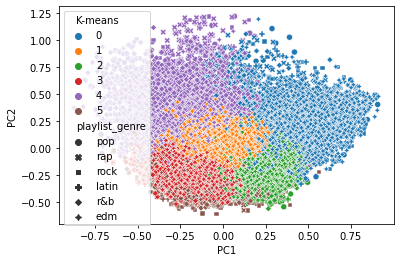

In [ ]:
cls_constrained = KMeansConstrained(n_clusters=6, size_min=4951, size_max=6043, init="random")
cls_constrained.fit(data_bf_np)
labels_constrained = pd.Series(cls_constrained.labels_,name="K-means")
scatterplot_pca(data=data_bf_np,hue=labels_constrained,style=spotify_data_cleaned.playlist_genre)

In [ ]:
data_kmeans_constrained = spotify_data_cleaned
data_kmeans_constrained["labels_constrained"] = labels_constrained
data_kmeans_constrained

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_album_release_month,track_album_release_year,labels_constrained
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754,06,2019,3
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600,12,2019,3
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616,07,2019,3
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093,07,2019,1
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052,03,2019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375,04,2014,1
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120,03,2013,0
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112,04,2014,2
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,...,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432,01,2014,0


In [ ]:
genres = ["rap","rock","r&b","latin","edm","pop"]
for genre in genres:
    print("----------------")
    mask_label = data_kmeans_constrained.playlist_genre == genre
    data_masked = data_kmeans_constrained.loc[mask_label]
    print(genre, "(",data_masked.shape[0],")")
    
    for i in range(5):
        mask_genre = data_masked.labels_constrained == i
        print("Labels ",i, " : ",data_masked.loc[mask_genre].shape[0]/data_kmeans_constrained.loc[mask_label].shape[0] * 100 , "%")

----------------
rap ( 5746 )
Labels  0  :  9.745910198398885 %
Labels  1  :  19.50922380786634 %
Labels  2  :  19.735468151757747 %
Labels  3  :  18.88270100939784 %
Labels  4  :  16.46362687086669 %
----------------
rock ( 4951 )
Labels  0  :  13.02767117753989 %
Labels  1  :  14.178953746717834 %
Labels  2  :  13.148858816400727 %
Labels  3  :  3.7770147444960616 %
Labels  4  :  8.887093516461322 %
----------------
r&b ( 5431 )
Labels  0  :  5.02669858221322 %
Labels  1  :  12.833732277665256 %
Labels  2  :  20.916958202909225 %
Labels  3  :  12.631191309151168 %
Labels  4  :  28.779230344319647 %
----------------
latin ( 5155 )
Labels  0  :  6.886517943743938 %
Labels  1  :  13.501454898157128 %
Labels  2  :  19.922405431619786 %
Labels  3  :  38.001939864209504 %
Labels  4  :  15.674102812803103 %
----------------
edm ( 6043 )
Labels  0  :  42.09829554856859 %
Labels  1  :  23.63064702962105 %
Labels  2  :  16.200562634453085 %
Labels  3  :  12.328313751447956 %
Labels  4  :  5.08

In [ ]:
genres = ["rap","rock","r&b","latin","edm","pop"]
for i in range(6):
    print("----------------")
    print("Label " , i, "(",data_masked.shape[0],")")
    mask_label = data_kmeans_constrained.labels_constrained == i
    data_masked = data_kmeans_constrained.loc[mask_label]
    
    for genre in genres:
        mask_genre = data_masked.playlist_genre == genre
        print(genre, " : ",data_masked.loc[mask_genre].shape[0]/data_kmeans_constrained.loc[mask_label].shape[0] * 100 , "%")


----------------
Label  0 ( 5507 )
rap  :  11.310846293678045 %
rock  :  13.02767117753989 %
r&b  :  5.514037568168047 %
latin  :  7.170268632599475 %
edm  :  51.38355887699455 %
pop  :  11.593617451019995 %
----------------
Label  1 ( 4951 )
rap  :  18.550388879695515 %
rock  :  11.61674664901539 %
r&b  :  11.534006288267417 %
latin  :  11.517458216117822 %
edm  :  23.63064702962105 %
pop  :  23.150752937282807 %
----------------
Label  2 ( 6043 )
rap  :  19.239904988123516 %
rock  :  11.045130641330166 %
r&b  :  19.273837801153714 %
latin  :  17.424499491007804 %
edm  :  16.610111978282998 %
pop  :  16.4065151001018 %
----------------
Label  3 ( 5894 )
rap  :  17.95465828231011 %
rock  :  3.0944894919741848 %
r&b  :  11.351977494621876 %
latin  :  32.41767334105577 %
edm  :  12.328313751447956 %
pop  :  22.852887638590104 %
----------------
Label  4 ( 6043 )
rap  :  19.10725106039184 %
rock  :  8.887093516461322 %
r&b  :  31.56937992324783 %
latin  :  16.31993536659261 %
edm  :  6.20

### Conclusion : PAS OUF

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2ad4461-7f35-42f5-b2d9-f686e8952f67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>